In [2]:
import pandas as pd
import numpy as np
import multiprocessing
from bs4 import BeautifulSoup as bs
from selectolax.parser import HTMLParser
import re
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string


#preprocessing
import re
import pymorphy2
import nltk
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet
import matplotlib.pyplot as plt
import string

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency

# Load the TensorBoard notebook extension
%load_ext tensorboard

# import logging  # Setting up the loggings to monitor gensim
# logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/adwiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/adwiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Data loading and preparation
data = pd.read_json('../datasets/dataset.json')
mapping = {False: 0, True: 1}
data.replace({'hasBadWords': mapping}, inplace=True)
# data.hasBadWords = data.hasBadWords.apply(lambda x: 1 if x == True else 0)
data.rename(columns={"hasBadWords": "labels"}, inplace=True)
data.drop(['violation'], axis=1, inplace=True)
data.shape

In [ ]:
data.head()

# Preprocessing function

In [ ]:
def preprocess(text, stop_words, punctuation_marks): #, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = token #morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)
    return ' '.join(preprocessed_text)

punctuation_marks = ['!', ',', ';', ':', '(', ')', '-', '--', '?', '@', '....', '~',
                     '.', '..', '...', '....................', '<', '>', '=', '»', '|', '’', '`', '+', '$',
                     '&', '#', '+++', '*', '``', '%', '[', ']', '{', '}', '√©']

stop_words = stopwords.words('english') + ['14000kbps', 'november', '1080p', '4k', 'mp4', 'error', '404', '2022']
morph = pymorphy2.MorphAnalyzer(lang='uk')

In [4]:
# function to clean and pre-process the text.
def clean_text(text):  
    
    # 1. Removing html tags
    text = bs(text,"lxml").get_text()
    
    # 2. Retaining only alphabets.
    text = re.sub("[^a-zA-Z]"," ", text)
    
    # 3. Converting to lower case and splitting
    word_tokens = text.lower().split()
    
    # 4. Remove stopwords
    le = WordNetLemmatizer()
    stop_words = set(stopwords.words("english")+ ['14000kbps', 'november', '1080p', 'email', 
                                                 '4k', 'mp4', 'error', '404', '2022'])     
    word_tokens = [le.lemmatize(w) for w in word_tokens if not w in stop_words]
    
    cleaned_review = " ".join(word_tokens)
    return cleaned_review

In [ ]:
def normalize(s):
    """
    Given a text, cleans and normalizes it. Feel free to add your own stuff.
    """
    s = s.lower()
    # Replace ips
    s = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' _ip_ ', s)
    # Isolate punctuation
    s = re.sub(r'([.\(\)\!\?\-\\\/\,])', r' \1 ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Replace numbers and symbols with language
    s = s.replace('&', ' and ')
    s = s.replace('@', ' at ')
    s = s.replace('0', ' zero ')
    s = s.replace('1', ' one ')
    s = s.replace('2', ' two ')
    s = s.replace('3', ' three ')
    s = s.replace('4', ' four ')
    s = s.replace('5', ' five ')
    s = s.replace('6', ' six ')
    s = s.replace('7', ' seven ')
    s = s.replace('8', ' eight ')
    s = s.replace('9', ' nine ')
    return s

In [ ]:
data[:1000].apply(lambda row: str(row.text), axis=1)

In [ ]:
# data[:100].apply(lambda row: bs(row['text']).get_text().replace('\n',' '),axis=1)

In [ ]:
data[:100].apply(lambda row: preprocess(row.text, punctuation_marks, stop_words), axis=1) #, morph), axis=1)

In [ ]:
# Dropping the rows with "<div"
# identify partial string
discard = ["<div ", "<p ", "<span ", "<p>", "<div>", "<h", "<input ", "center>", "<a ", 
           "<td>", "<", ">", r"              ", "Ø", '√ú', 'http://']
  
data = data[~data.text.str.contains('|'.join(discard))]

In [ ]:
data['text'] = data.apply(lambda row: bs(row.text, 'lxml').get_text().replace('\r\n', ' ').replace('/', ' ').replace('"', '\"'), axis=1)
# data['text'] = data.apply(lambda row: HTMLParser(row.text).body.text(separator=' ').replace('\r\n',' '),axis=1)

In [ ]:
data['text_preprocessed'] = data.apply(lambda row: preprocess(row.text, punctuation_marks, stop_words), axis=1)

In [ ]:
data

In [ ]:
longest_string = data.text.apply(lambda x: len(x))
longest_string

In [ ]:
data = data[['text_preprocessed', 'labels', 'text']] # columns reorder

In [ ]:
data.head()

In [ ]:
# data.to_csv('../datasets/clear_text.csv')

# Tensorflow

In [5]:
# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count  

In [ ]:
counter = counter_word(data.text_preprocessed)  

In [ ]:
data.text_preprocessed

In [ ]:
num_unique_words = len(counter)
oov_token = '<UNK>'

In [ ]:
num_unique_words

In [ ]:
counter

In [ ]:
counter.most_common(150)

In [ ]:
from wordcloud import *
word_freq = [i for i in counter.most_common(50)]
wd = WordCloud(background_color='white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
train_size = int(data.shape[0] * .8)

train = data[:train_size]
val = data[train_size:]

# Split train and test

X_train = train.text_preprocessed.to_numpy()
y_train = train.labels.to_numpy()

X_val = val.text_preprocessed.to_numpy()
y_val = val.labels.to_numpy()

In [ ]:
train.text_preprocessed.to_numpy()

In [ ]:
X_train,  y_train

In [ ]:
X_train.shape, X_val.shape

# Tokenize

In [ ]:
# vectorize a text corpus by turning each text into sentence of integers

tokenizer2 = Tokenizer(num_words=num_unique_words, oov_token=oov_token)
tokenizer2.fit_on_texts(X_train)

In [ ]:
import pickle

# saving
with open('../models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer2, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('../models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
# each word have a unique index
word_index = tokenizer.word_index
word_index

In [ ]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

In [ ]:
print(X_train[1])
print(X_train_sequences[1])

In [ ]:
# pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# max words in a sequence
max_length = 100 #max([len(x) for x in X_train_sequences]) #256

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding="post", truncating="post")
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding="post", truncating="post")

X_train_padded.shape, X_val_padded.shape


In [ ]:
X_train_padded[10]

In [ ]:
print(X_train[10])
print(X_train_sequences[10])
print(X_train_padded[10])

In [ ]:
# Check reversing the indices

# flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [ ]:
reverse_word_index

In [ ]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

decoded_text = decode(X_train_sequences[10])

print(X_train_sequences[10])
print(decoded_text)

In [ ]:
# Create LSTM model
from tensorflow.keras import layers

# Word embeddings give us a way to use an efficient, dense representation in which similar words have
# a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a 
# dense vector of floating point values (the length of the vector is a parameter you specify)

# tf.debugging.set_log_device_placement(True)

model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=max_length))

# The layer will take as input as integer matrix of size (batcg, input_length)
# and the largest integer (i.e. word index) in the input should be no larger than num_words (vocabulary size).
# Now model.output_shape is (None, input_length, 32), where `None` is the batch dimension.

model.add(layers.LSTM(64, dropout=.1))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

In [ ]:
# draw model
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
from pathlib import Path
from tensorflow.keras.models import load_model

path = Path('../models/bad_words')
path.mkdir(exist_ok=True) 
cpt_filename = '{epoch:02d}_checkpoint_{val_loss:.2f}.hdf5'
cpt_path = str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_loss', verbose=1, 
                                                save_best_only=True, mode='min')

In [ ]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = keras.optimizers.legacy.Adam(learning_rate=.001)
metrics = ['accuracy']

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
# model.fit(X_train_padded, y_train, epochs=10, validation_data=(X_val_padded, y_val), verbose=1, 
#           callbacks=[checkpoint])

In [ ]:
# model.get_weights()

In [ ]:
# history_df = pd.DataFrame(model.history.history)
# history_df.head(15)

In [ ]:
# import matplotlib.pyplot as plt
# plt.plot(history_df.loss);

In [ ]:
model.load_weights('../models/bad_words/09_checkpoint_0.02.hdf5') # loading weights - model had created erlier
loss, acc = model.evaluate(X_val_padded, y_val)
print(f'Accuracy of restored model {acc*100:.2f}%')

In [ ]:
model = tf.keras.models.load_model('../models/bad_words/09_checkpoint_0.02.hdf5')
loss, acc = model.evaluate(X_val_padded, y_val)
print(f'Accuracy of restored model {acc*100:.2f}%')

In [ ]:
# !ls '../models/bad_words'

In [ ]:
predictions = model.predict(X_train_padded)
predictions = [1 if p > .5 else 0 for p in predictions]

In [ ]:
X_train_padded[0]

In [ ]:
print(X_train[2000:2010])
print(y_train[2000:2010])
print(predictions[2000:2010])

In [ ]:
train['predictions'] = predictions
train = train[['text_preprocessed', 'labels', 'predictions', 'text']] # columns reorder

In [ ]:
train.head()

In [ ]:
# train.to_csv('../datasets/wo_html.csv')

In [7]:
# model.save('../models/modelSequential_HTML_final.h5')
model = keras.models.load_model('../models/modelSequential_HTML_final.h5')

In [6]:
# model_new = keras.models.load_model('../models/modelSequential_wo_HTML.h5')
model_new = keras.models.load_model('../models/bad_words/09_checkpoint_0.02.hdf5')

Metal device set to: Apple M2


In [ ]:
df = pd.read_csv('../datasets/BadWordsService_ml_has.csv')
df.head()

In [ ]:
predictions = model_new.predict(X_train_padded)
predictions = [1 if p > .5 else 0 for p in predictions]

In [ ]:
# with open('../datasets/sub.txt', 'r') as file:
#     raw_text = ''.join(file.readlines())

# raw_text

In [ ]:
def read_train_data():
    data = pd.read_json('../datasets/dataset.json')
    mapping = {False: 0, True: 1}
    data.replace({'hasBadWords': mapping}, inplace=True)
    data.rename(columns={"hasBadWords": "labels"}, inplace=True)
    data.rename(columns={"text": "raw_text"}, inplace=True)
    data.drop(['violation'], axis=1, inplace=True)
    print('Data size %d' % len(data))
    print('Data headers %s' % data.columns.values)
    return data

In [8]:
# df_pos = pd.read_csv('../datasets/BadWordsService_ml.csv')
# df_neg =  pd.read_csv('../datasets/BadWordsService_ml_non.csv')
df = pd.read_csv('../datasets/BadWordsService_ml_has.csv')

In [9]:
# df_pos.drop('@timestamp', axis=1, inplace=True)
# df_neg.drop('@timestamp', axis=1, inplace=True)
# df_neg.drop('@timestamp', axis=1, inplace=True)

In [10]:
# df_pos.rename(columns={"ctxt_.text": "raw_text"}, inplace=True)
# df_neg.rename(columns={"ctxt_.text": "raw_text"}, inplace=True)
df.rename(columns={"ctxt_.text": "raw_text"}, inplace=True)
df.rename(columns={"ctxt_.time_spent": "time_spent"}, inplace=True)

In [11]:
# df_pos.head()

In [12]:
# df_neg.head()

In [13]:
df.head()

,@timestamp,@timestamp.1,time_spent,raw_text
0,"May 12, 2023 @ 03:55:19.552","May 12, 2023 @ 03:55:19.552",0.3,This is the 320x240 version of...Leah clip nin...
1,"May 12, 2023 @ 03:55:19.451","May 12, 2023 @ 03:55:19.451",0.1,control forced orgasm spanking spankings horn...
2,"May 12, 2023 @ 03:54:33.258","May 12, 2023 @ 03:54:33.258",1.0,start\tend\ttext\n0\t12920\tLet's go with this...
3,"May 12, 2023 @ 03:54:24.778","May 12, 2023 @ 03:54:24.778",0.3,<p>Hi guys!! Here I am with you after doing so...
4,"May 12, 2023 @ 03:54:23.157","May 12, 2023 @ 03:54:23.157",0.1,start\tend\ttext\n0\t3000\tI regret that I can...


In [14]:
# df_pos['labels'] = 1
# df_neg['labels'] = 0

In [15]:
# df_pos.head()

In [16]:
# nan_values = df_neg[df_neg.isna().any(axis=1)]
# print(len(nan_values))

In [17]:
# df_neg.dropna(inplace=True)
# df_neg.head()

In [18]:
# df_pos['text'] = df_pos.apply(lambda row: clean_text(row.raw_text), axis=1)
# df_neg['text'] = df_neg.apply(lambda row: clean_text(row.raw_text), axis=1)
df['text'] = df.apply(lambda row: clean_text(row.raw_text), axis=1)

In [19]:
# df_pos.head()

In [20]:
# df_neg.head()

In [21]:
df.head()

,@timestamp,@timestamp.1,time_spent,raw_text,text
0,"May 12, 2023 @ 03:55:19.552","May 12, 2023 @ 03:55:19.552",0.3,This is the 320x240 version of...Leah clip nin...,x version leah clip nine mind reduction laughi...
1,"May 12, 2023 @ 03:55:19.451","May 12, 2023 @ 03:55:19.451",0.1,control forced orgasm spanking spankings horn...,control forced orgasm spanking spanking horny ...
2,"May 12, 2023 @ 03:54:33.258","May 12, 2023 @ 03:54:33.258",1.0,start\tend\ttext\n0\t12920\tLet's go with this...,start end text let go drive go going already c...
3,"May 12, 2023 @ 03:54:24.778","May 12, 2023 @ 03:54:24.778",0.3,<p>Hi guys!! Here I am with you after doing so...,hi guy something really extreme decoration sto...
4,"May 12, 2023 @ 03:54:23.157","May 12, 2023 @ 03:54:23.157",0.1,start\tend\ttext\n0\t3000\tI regret that I can...,start end text regret anything wrong tweeted c...


In [22]:
# df_pos.drop('raw_text', axis=1, inplace=True)
# df_neg.drop('raw_text', axis=1, inplace=True)
df.drop('raw_text', axis=1, inplace=True)

In [23]:
# df_pos.shape, df_neg.shape

In [24]:
# df = pd.concat([df_pos, df_neg], ignore_index=True)
df.shape

(4234, 4)

In [25]:
df.head()

,@timestamp,@timestamp.1,time_spent,text
0,"May 12, 2023 @ 03:55:19.552","May 12, 2023 @ 03:55:19.552",0.3,x version leah clip nine mind reduction laughi...
1,"May 12, 2023 @ 03:55:19.451","May 12, 2023 @ 03:55:19.451",0.1,control forced orgasm spanking spanking horny ...
2,"May 12, 2023 @ 03:54:33.258","May 12, 2023 @ 03:54:33.258",1.0,start end text let go drive go going already c...
3,"May 12, 2023 @ 03:54:24.778","May 12, 2023 @ 03:54:24.778",0.3,hi guy something really extreme decoration sto...
4,"May 12, 2023 @ 03:54:23.157","May 12, 2023 @ 03:54:23.157",0.1,start end text regret anything wrong tweeted c...


In [26]:
# df = df[['text', 'labels']]#, 'raw_text']] # columns reorder
# df.head()

In [27]:
counter = counter_word(df.text)  

In [28]:
num_unique_words = len(counter)
oov_token = '<UNK>'

In [29]:
num_unique_words

12560

In [30]:
counter

Counter({'x': 2200,
         'version': 3405,
         'leah': 11,
         'clip': 5542,
         'nine': 209,
         'mind': 1642,
         'reduction': 137,
         'laughing': 118,
         'faster': 90,
         'downloading': 25,
         'think': 1572,
         'joking': 6,
         'first': 1239,
         'tell': 865,
         'turn': 860,
         'mindless': 1192,
         'horny': 841,
         'sex': 315,
         'object': 24,
         'even': 2092,
         'laugh': 169,
         'thinking': 161,
         'serious': 129,
         'blatantly': 1,
         'going': 2857,
         'happen': 203,
         'curious': 55,
         'little': 2697,
         'girl': 3190,
         'see': 2538,
         'mask': 15,
         'hand': 1659,
         'seems': 884,
         'worried': 26,
         'well': 1886,
         'say': 2082,
         'one': 3332,
         'deep': 532,
         'breath': 304,
         'late': 189,
         'anyway': 416,
         'slowly': 984,
         'go': 

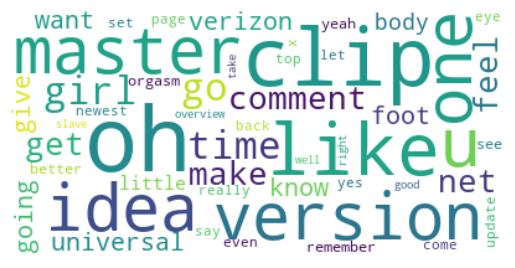

In [31]:
from wordcloud import *
word_freq = [i for i in counter.most_common(50)]
wd = WordCloud(background_color='white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [32]:
# train_size = int(df.shape[0] * .8)

# train = df[:train_size]
# val = df[train_size:]

# # Split train and test

# X_train = train.text.to_numpy()
# y_train = train.labels.to_numpy()

# X_val = val.text.to_numpy()
# y_val = val.labels.to_numpy()

In [33]:
# train.text.to_numpy()

In [34]:
X = df.text.to_numpy()

In [ ]:
X_train,  y_train

In [ ]:
X_train.shape, X_val.shape

In [39]:
import pickle

# loading
with open('../models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [54]:
# vectorize a text corpus by turning each text into sentence of integers

tokenizer = Tokenizer(num_words=num_unique_words, oov_token=oov_token)
tokenizer.fit_on_texts(X)

In [55]:
# each word have a unique index
word_index = tokenizer.word_index
word_index['clip']

3

In [44]:
len(word_index.keys())

12561

In [45]:
46057 + 37614

83671

In [46]:
# X_train_sequences = tokenizer.texts_to_sequences(X_train)
# X_val_sequences = tokenizer.texts_to_sequences(X_val)

In [51]:
X_sequences = tokenizer.texts_to_sequences(X)

In [52]:
# print(X_train[1])
# print(X_train_sequences[1])

In [53]:
print(X[1])
print(X_sequences[1])

control forced orgasm spanking spanking horny girl girl masturbation sleepy mind control masturbating girl vibrator vibrator toy fantasy helpless helples forced bondage imagine dildo dildo toy toy toy play solo masturbation wet girl masturbating slut control ethnic amateur audition domination ethnic foot fetish footjobs foot sensual massage shower scene napping fetish sol voyer submissive slut tickling
[66, 259, 27, 493, 493, 108, 10, 10, 218, 669, 54, 66, 562, 10, 379, 379, 237, 411, 332, 1741, 259, 391, 514, 449, 449, 237, 237, 237, 124, 1375, 218, 180, 10, 562, 486, 66, 1179, 1602, 1351, 413, 1179, 24, 205, 1814, 24, 311, 745, 1061, 450, 1239, 205, 651, 1878, 374, 486, 243]


In [ ]:
# pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# max words in a sequence
max_length = 100 #max([len(x) for x in X_train_sequences]) #256

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding="post", truncating="post")
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding="post", truncating="post")

X_train_padded.shape, X_val_padded.shape

In [ ]:
X_train_padded[10]

In [ ]:
print(X_train[10])
print(X_train_sequences[10])
print(X_train_padded[10])

In [ ]:
# Check reversing the indices

# flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])
reverse_word_index

In [ ]:
# model.fit(X_train_padded, y_train, epochs=10, validation_data=(X_val_padded, y_val), verbose=1, 
#           callbacks=[checkpoint])

In [ ]:
history_df = pd.DataFrame(model.history.history)
history_df.head(15)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_df.loss);

# Check sentence

In [122]:
#preprocessing
import re
import pymorphy2
import nltk
from datetime import datetime 
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet
import matplotlib.pyplot as plt
import string
# pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# raw_text = "Welcome to Jandro The Tickler. What \
#           you're seeing here is completely real! So here's the premise: Husbands, \
#           boyfriends, friends, etc, hire me, \"The Tickler\", to show \
#           up at a specified location at a specific time with one mission: Find \
#           the girl, tie her up, surprise her, and tickle the hell out of her! \
#           Sometimes the girls are in the know, and sometimes they're not:) The \
#           bonds are real, the reactions are certainly real, and the tickle tools \
#           are 100% real. The end result is usually a surprised, shocked, tortured, \
#           turned on, worn out girl, with hardly the strength to wave at the camera \
#           before I exit:) I basically wanted to combine Tickle Torture with Foot, \
#           Sleepy, Voyeur, Light Bondage, and even Forced O. The premise allows \
#           all of these to take place per vid."
raw_text = """  """
# test_text_preprocessed = clean_text(raw_text)
# test_text_preprocessed = clean_text(X.text)
# bs(raw_text, 'lxml').get_text().replace('\n',' ').replace('\t',' ') 
# test_text_preprocessed = preprocess(test_text_preprocessed, punctuation_marks, stop_words)

######## new
import itertools as itt
chunksize = 100

# loading
# with open('../models/tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)
    
# vectorize a text corpus by turning each text into sentence of integers
max_len = 100
tokenizer = Tokenizer(num_words=num_unique_words, oov_token=oov_token)
# tokenizer.fit_on_texts(X)
tmp_dict = {}
values = []
keys = ['text', 'time_elapsed','label']
for elem in df.text[:15]:
    myseq = elem #test_text_preprocessed
    cnt = itt.count()
    test_text_np = np.array([''.join(grp) for k, grp in itt.groupby(myseq, key=lambda x: next(cnt)//chunksize%2)])
    tokenizer.fit_on_texts(test_text_np)
    test_sequences = tokenizer.texts_to_sequences(test_text_np)   
    test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding="post", truncating="post")
    print(test_text_np)
    print('LEN', len(test_text_np))
    print('test_sequences', test_sequences)
    print('test_sequences_padded', test_sequences_padded)
    
    # for word in test_text_preprocessed:
    # Get max training sequence length
    start_time = datetime.now() 
  


    predictions = model.predict(test_sequences_padded)
    predictions = [1 if p > .5 else 0 for p in predictions]

    time_elapsed = datetime.now() - start_time 

#     print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))
#     print('Prediction:', max(predictions))
    values = [myseq, time_elapsed, max(predictions)]
    print('----------', values)
    tmp_dict = { zip(keys, values) }
    print('++++++++++', tmp_dict)
#     tmp_dict = {zip(keys, values)}
    values.append(tmp_dict.copy())

# df = pd.DataFrame(list(zip(lst, lst2)),
#                columns =['Name', 'val'])   
df_result = pd.DataFrame(data=values, columns=['text', 'time_elapsed','label'], index=None)
########
# test_text_np = np.array([test_text_preprocessed])
# test_sequences = tokenizer.texts_to_sequences(test_text_np)

['x version leah clip nine mind reduction laughing faster downloading leah think joking first tell tur'
 'n mindless horny sex object even laugh thinking serious blatantly tell going happen leah curious lit'
 'tle girl see mask hand seems curious worried well say one deep breath late anyway leah slowly go hap'
 'py completely uninhibited horny promiscuous state mindlessness every time put mask face dramatic tra'
 'nsformation becomes obvious body finally shivering shaking bliss leah beautiful breast jiggling noth'
 'ing else sex mind eventually surrender adding clip series next day due nature story always update to'
 'wards bottom order keep story line tact check date comment idea u universal verizon net']
LEN 7
test_sequences [[11, 12, 2, 3, 13, 4, 14, 15, 16, 17, 2, 18, 19, 20, 5, 21], [22, 23, 6, 7, 24, 25, 26, 27, 28, 29, 5, 30, 31, 2, 8, 32], [33, 34, 35, 9, 36, 37, 8, 38, 39, 40, 41, 42, 43, 44, 45, 2, 46, 47, 48], [49, 50, 51, 6, 52, 53, 54, 55, 56, 57, 9, 58, 59, 60], [61, 62, 

1/1 [==============================] - 0s 13ms/step
---------- ['start end text let go drive go going already come turn around turn around first yes well come turn around turn around turn around turn around turn around yes come turn around turn around turn around turn around turn around turn around oh street right come walking oh going already sit still gosh forward righty one one turn around turn around turn around turn around turn around yes best run yes come jump turn around yes jump turn around turn around turn around turn around turn around turn around turn around yes fast yes fast like lesson side side yes opportunity sight lesson yes whether straight yeah fast itarnya fast ground back sit higher please sit teach u back house u sit higher yes yes sit middle ok ok hold want lose yeah yeah nice yeah thank yeah must good say must turn turn make nice round huh yeah blind horse blind horse yeah come maybe yeah look everybody slow horse turn around turn around turn around slow horse oh

1/1 [==============================] - 0s 11ms/step
---------- ['step mommy continues training little boy ritualized milking anal training program second video series training boy take larger larger butt plug dilator please milk away nasty cum step mommy love using boy big plan future spread as wider wider step mommy tie little boy ball drain spread as little boy help give huge load cum please step mommy anything step mommy step mommy successive video step mommy spread little boy as wider wider trained take largest butt plug step mommy reward draining ball hot creamy cum step mommy boy never allowed cum unless presence controlled exclusively step mommy step mommy definitely owns orgasm little boy anything please step mommy', datetime.timedelta(microseconds=27931), 0]
++++++++++ {<zip object at 0x4959cba00>}
['amber nadia clip seven mindless balloon blowing next segment leaf two beauty mindless orgasmed froze'
 'n place start pretty harmless balloon blowing contest amber nadia know thou

1/1 [==============================] - 0s 11ms/step
---------- ['control forced orgasm spanking spanking horny girl girl masturbation sleepy mind control masturbating girl vibrator vibrator toy fantasy helpless helples forced bondage imagine dildo dildo toy toy toy play solo masturbation wet girl masturbating slut control ethnic amateur audition domination ethnic foot fetish footjobs foot sensual massage shower scene napping fetish sol voyer submissive slut tickling', datetime.timedelta(microseconds=26587), 1]
++++++++++ {<zip object at 0x4959f7680>}
['arielle lane received electric chair limp body slump guard scott torvea finish declaration witness g'
 'urney guard cover white cloth attache toe tag nude body walk past hand shoot grab wrist arielle sits'
 ' scott shock employer want redo electrocution scott know chair need refractory period hopeful go hom'
 'e botched first case point chair sits talking last zap started like pin needle hurt long everything '
 'went white scott nod stra

1/1 [==============================] - 0s 11ms/step
---------- ['lady scarlet femdom assault', datetime.timedelta(microseconds=23009), 0]
++++++++++ {<zip object at 0x499f8c440>}
['starring arielle lane bliss dulce dakota charm scott torvea adam torvea arielle lane lounging couch '
 'knock door jump answer open door turn let everyone know pizza unfortunately delivery masked men run '
 'house grab arielle behind struggle resist pick cradle carry back couch next sneak bedroom bliss gett'
 'ing ready quickly put mouth put much fight drag room next rush grab dakota let short scream subdues '
 'well bikini led dark warehouse chain linked together made walk single file finally led room noose ha'
 'nging rope put girl sudden arielle wake bothered dream run bathroom tell dakota happened knock door '
 'bliss bedroom go answer open door turn tell others pizza grabbed masked man masked man go see else h'
 'ouse meanwhile arielle still trying tell dakota dream sudden two men rush bathroom grab gir

1/1 [==============================] - 0s 12ms/step
---------- ['arielle lane tried jury following botched gem heist resulted demise four people jury found guilty sentenced executed electric chair video open arielle making way towards electric chair dressed blazer shiny green shirt tight short skirt sheer black thigh high black high heel arielle reluctantly walk towards electric chair hand cuffed behind back prison guard follows closely behind arielle reach electric chair guard remove handcuff tell seat arielle nervous seems remorseful late fate sealed guard secures arielle electric chair strap wrist arm chair ankle spread apart either side secures strap across waist two strap around thigh pulling apart two strap added upper arm firmly securing electric chair arielle guaranteed remain electric chair guard fastens electrode leg arielle seems calm reality situation setting hand grip end chair grapple impending demise guard double check arielle secured chair read sentence prisoner sentenc

1/1 [==============================] - 0s 11ms/step
---------- ['starring arielle lane scott torvea arielle laying floor pink panty hand handcuffed behind back scott torvea come slap face bring pick take stool put stool place rope around neck rope pulled tight force stand stool tip toe long hang lot close ups foot toe keywords jail fetish prison fetish prisoner fetish brunette redhead autumn borrelli custom would like please u', datetime.timedelta(microseconds=25758), 0]
++++++++++ {<zip object at 0x49dd523c0>}


ValueError: Shape of passed values is (4, 1), indices imply (4, 3)

In [125]:
len(values)

4

In [59]:
st = 'arielle lane received electric chair limp body slump guard scott torvea finish declaration witness g'
print(len(st.strip()))

100


In [63]:
tmp_dict

{'text': 'x version leah clip nine mind reduction laughing faster downloading leah think joking first tell turn mindless horny sex object even laugh thinking serious blatantly tell going happen leah curious little girl see mask hand seems curious worried well say one deep breath late anyway leah slowly go happy completely uninhibited horny promiscuous state mindlessness every time put mask face dramatic transformation becomes obvious body finally shivering shaking bliss leah beautiful breast jiggling nothing else sex mind eventually surrender adding clip series next day due nature story always update towards bottom order keep story line tact check date comment idea u universal verizon net',
 'time_elapsed': datetime.timedelta(microseconds=40181),
 'label': 0}

In [60]:
df

,@timestamp,@timestamp.1,time_spent,text
0,"May 12, 2023 @ 03:55:19.552","May 12, 2023 @ 03:55:19.552",0.3,x version leah clip nine mind reduction laughi...
1,"May 12, 2023 @ 03:55:19.451","May 12, 2023 @ 03:55:19.451",0.1,control forced orgasm spanking spanking horny ...
2,"May 12, 2023 @ 03:54:33.258","May 12, 2023 @ 03:54:33.258",1.0,start end text let go drive go going already c...
3,"May 12, 2023 @ 03:54:24.778","May 12, 2023 @ 03:54:24.778",0.3,hi guy something really extreme decoration sto...
4,"May 12, 2023 @ 03:54:23.157","May 12, 2023 @ 03:54:23.157",0.1,start end text regret anything wrong tweeted c...
...,...,...,...,...
4229,"May 11, 2023 @ 23:28:17.462","May 11, 2023 @ 23:28:17.462",0.5,x version milan clip four nothing obedient sla...
4230,"May 11, 2023 @ 23:28:17.439","May 11, 2023 @ 23:28:17.439",0.4,hd p version milan clip five controlled slave ...
4231,"May 11, 2023 @ 23:28:17.382","May 11, 2023 @ 23:28:17.382",0.6,hd p version milan clip three control master f...
4232,"May 11, 2023 @ 23:28:17.378","May 11, 2023 @ 23:28:17.378",0.6,x version milan clip three control master firs...


In [ ]:
len(test_sequences)

In [ ]:
# raw_text = "After a morning of horse-back riding, Sara Domina returns home with her boots dirtied, the soles soiled with .....Her slave is in waiting, unawares of what is about to happen to him ....."

# test_text_preprocessed = bs(raw_text, 'lxml').get_text().replace('\r\n',' ')
# test_text_preprocessed = preprocess(test_text_preprocessed, punctuation_marks, stop_words)

######## new
# import itertools as itt
# chunksize = 100
# myseq = raw_text
# cnt = itt.count()
# test_text_np = np.array([ ''.join(grp) for k,grp in itt.groupby(myseq, key=lambda x: next(cnt)//chunksize%2)])
# test_sequences = tokenizer.texts_to_sequences(test_text_np)
########
# test_text_np = np.array([test_text_preprocessed])
# test_sequences = tokenizer.texts_to_sequences(test_text_np)

In [ ]:
test_text_np[10:10]

In [ ]:
test_sequences[-2]

In [ ]:
# for word in test_text_preprocessed:
# Get max training sequence length
max_len = 100

test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding="post", truncating="post")

In [ ]:
print(test_text_np)
print(test_sequences_padded)

In [ ]:
test_text_np

In [ ]:
start_time = datetime.now() 

predictions = model.predict(test_sequences_padded)
predictions = [1 if p > .5 else 0 for p in predictions]

time_elapsed = datetime.now() - start_time 

print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))


In [ ]:
%%time

predictions = model_new.predict(test_sequences_padded)
predictions = [1 if p > .5 else 0 for p in predictions]

In [ ]:
predictions

In [ ]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

def preprocess(text, stop_words, punctuation_marks): #, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = token #morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)
    return ' '.join(preprocessed_text)

punctuation_marks = ['!', ',', ';', ':', '(', ')', '-', '--', '?', '@', '....', '~', '¬ß'
                     '.', '..', '...', '....................', '<', '>', '=', '»', '|', '’', '`', '+', '$',
                     '&', '#', '+++', '*', '``', '%', '[', ']', '{', '}', '√©', '√™', '¬†', '√¢']


stop_words = stopwords.words('english') + ['14000kbps', 'https', "'s", "'m", 'http', 'mp4', 'error', '404',
                                          'Error 404', '404error']

# loading
with open('../models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
model = keras.models.load_model('../models/modelSequential_wo_HTML.h5')

raw_text = 'nigger'


def predict(sequences):
    sequences_padded = pad_sequences(sequences, maxlen=max_length, padding="post", truncating="post")
    predictions = model.predict(sequences_padded)
    predictions = [1 if p > .5 else 0 for p in predictions]
    return predictions

# Data loading and preparation
data = pd.read_json('../datasets/neil_ProducerClipSite_rand.json')
mapping = {False: 0, True: 1}
# data.replace({'hasBadWords': mapping}, inplace=True)
# data.hasBadWords = data.hasBadWords.apply(lambda x: 1 if x == True else 0)
# data.rename(columns={"hasBadWords": "labels"}, inplace=True)
data.drop(['SiteID', 'Title', 'Description', 'Keywords', 'Bottom'], axis=1, inplace=True)
data.head()



In [ ]:
data.Top

In [ ]:
%%time
data['text'] = data.apply(lambda row: bs(row.Top, 'lxml').get_text().replace('\r\n',' ').replace('.', ''), axis=1)
data['text_preprocessed'] = data.apply(lambda row: preprocess(row.text, punctuation_marks, stop_words), axis=1)

# Get max training sequence length
max_length = max([len(x) for x in X_val_sequences])

X_val = data.text_preprocessed.to_numpy()
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_val_padded = pad_sequences(X_val_sequences, maxlen=256, padding="post", truncating="post")
# X_val_padded = pad_sequences(X_val_sequences, padding="post", truncating="post")


predictions = model.predict(X_val_padded)
predictions = [1 if p > .5 else 0 for p in predictions]


In [ ]:

X_val_padded[100:102]


In [ ]:
data['predictions'] = predictions

In [ ]:
data.head()

In [ ]:
data = data[['Top', 'predictions']]

In [ ]:
data.to_csv('../datasets/last_one.csv')

In [ ]:
data.to_json('../datasets/last_one.json')